## Import Libraries

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
sns.set_style('darkgrid')

## Load Dataset

In [3]:
# Load csv
df = pd.read_csv("data/train.csv")

In [4]:
# Shape of dataframe
df.shape

(1460, 81)

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Utilities

In [6]:
def treat_missing_values(df):    
    # checking null values
    NA_col = df.isnull().sum()
    # find out columns which have nulls
    NA_col = NA_col[NA_col > 0]

    for col in NA_col.index:
        if df[col].dtype.name == 'object':
            # impute mode
            df[col].fillna(df[col].mode()[0], inplace=True)
            
        elif df[col].dtype.name == 'float64' or df[col].dtype.name == 'int64' or df[col].dtype.name == 'int32':
            # impute median
            df[col] = df[col].fillna((df[col].median()))
            
        else:
            print('Unable to detect the datatype for col - ', col)
            
    return df

In [7]:
def show_metrics(y_train, y_train_pred, y_test, y_pred):
    ## R-squared of train and test data
    metric = []
    print("R-Squared (Train) =", '%.2f' % r2_score(y_train, y_train_pred))
    metric.append(r2_score(y_train, y_train_pred))
    print("R-Squared (Test) =", '%.2f' % r2_score(y_test, y_pred))
    metric.append(r2_score(y_test, y_pred))
    return metric

## Data understanding and visualization

In [8]:
# Removing unnecessary columns
columns_to_drop = ["Id"]
df.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
# List of all columns where values are filled with only None
df.columns[df.isnull().sum()==df.shape[0]]

Index([], dtype='object')

In [10]:
# List of all columns where all rows contain same value
df.columns[df.nunique()==1]

Index([], dtype='object')

No column with all None value or same value present in all row.

In [11]:
# List number of missing values in each columns
((df.isna().sum() * 100) / len(df)).sort_values(ascending = False).head(10)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
dtype: float64

In [12]:
# New column for age of the house
df['Age'] = df['YrSold'] - df['YearBuilt']

In [13]:
# Removing columns more than 10% None value
df.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "LotFrontage", "YrSold", "YearBuilt"], inplace=True, axis=1)

In [14]:
df = treat_missing_values(df)

In [15]:
# checking null values
round(df.isnull().sum()/len(df.index),2)[round(df.isnull().sum()/ len(df.index),2).values>0.00]

Series([], dtype: float64)

In [16]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,WD,Normal,208500,5
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,WD,Normal,181500,31
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,WD,Normal,223500,7
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,WD,Abnorml,140000,91
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,WD,Normal,250000,8


In [17]:
df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,Age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890,36.547945
std,42.300571,9981.264932,1.382997,1.112799,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883,30.250152
min,20.000000,1300.000000,1.000000,1.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000
25%,20.000000,7553.500000,5.000000,5.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000,8.000000
50%,50.000000,9478.500000,6.000000,5.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,35.000000
75%,70.000000,11601.500000,7.000000,6.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000,54.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,136.000000


In [18]:
# Categorical Variable
categorical_columns = [
    "Age",
    "SaleCondition", 
    "SaleType", 
    "MoSold", 
    "PavedDrive", 
    "GarageCond", 
    "GarageQual", 
    "GarageFinish", 
    "GarageType", 
    "GarageYrBlt", 
    "Functional", 
    "KitchenQual", 
    "Electrical", 
    "CentralAir", 
    "HeatingQC", 
    "Heating", 
    "BsmtFinType2", 
    "BsmtFinType1", 
    "BsmtExposure", 
    "BsmtCond", 
    "BsmtQual", 
    "Foundation",
    "ExterCond", 
    "ExterQual", 
    "MasVnrType",
    "Exterior2nd", 
    "Exterior1st", 
    "RoofMatl", 
    "RoofStyle", 
    "YearRemodAdd", 
    "OverallCond", 
    "OverallQual", 
    "HouseStyle", 
    "BldgType", 
    "Condition2", 
    "Condition1", 
    "Neighborhood", 
    "LandSlope", 
    "LotConfig", 
    "Utilities", 
    "LandContour", 
    "LotShape", 
    "Street", 
    "MSZoning", 
    "MSSubClass"
]

In [19]:
# Continuous Variable
continuous_columns = [
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'SalePrice'
]

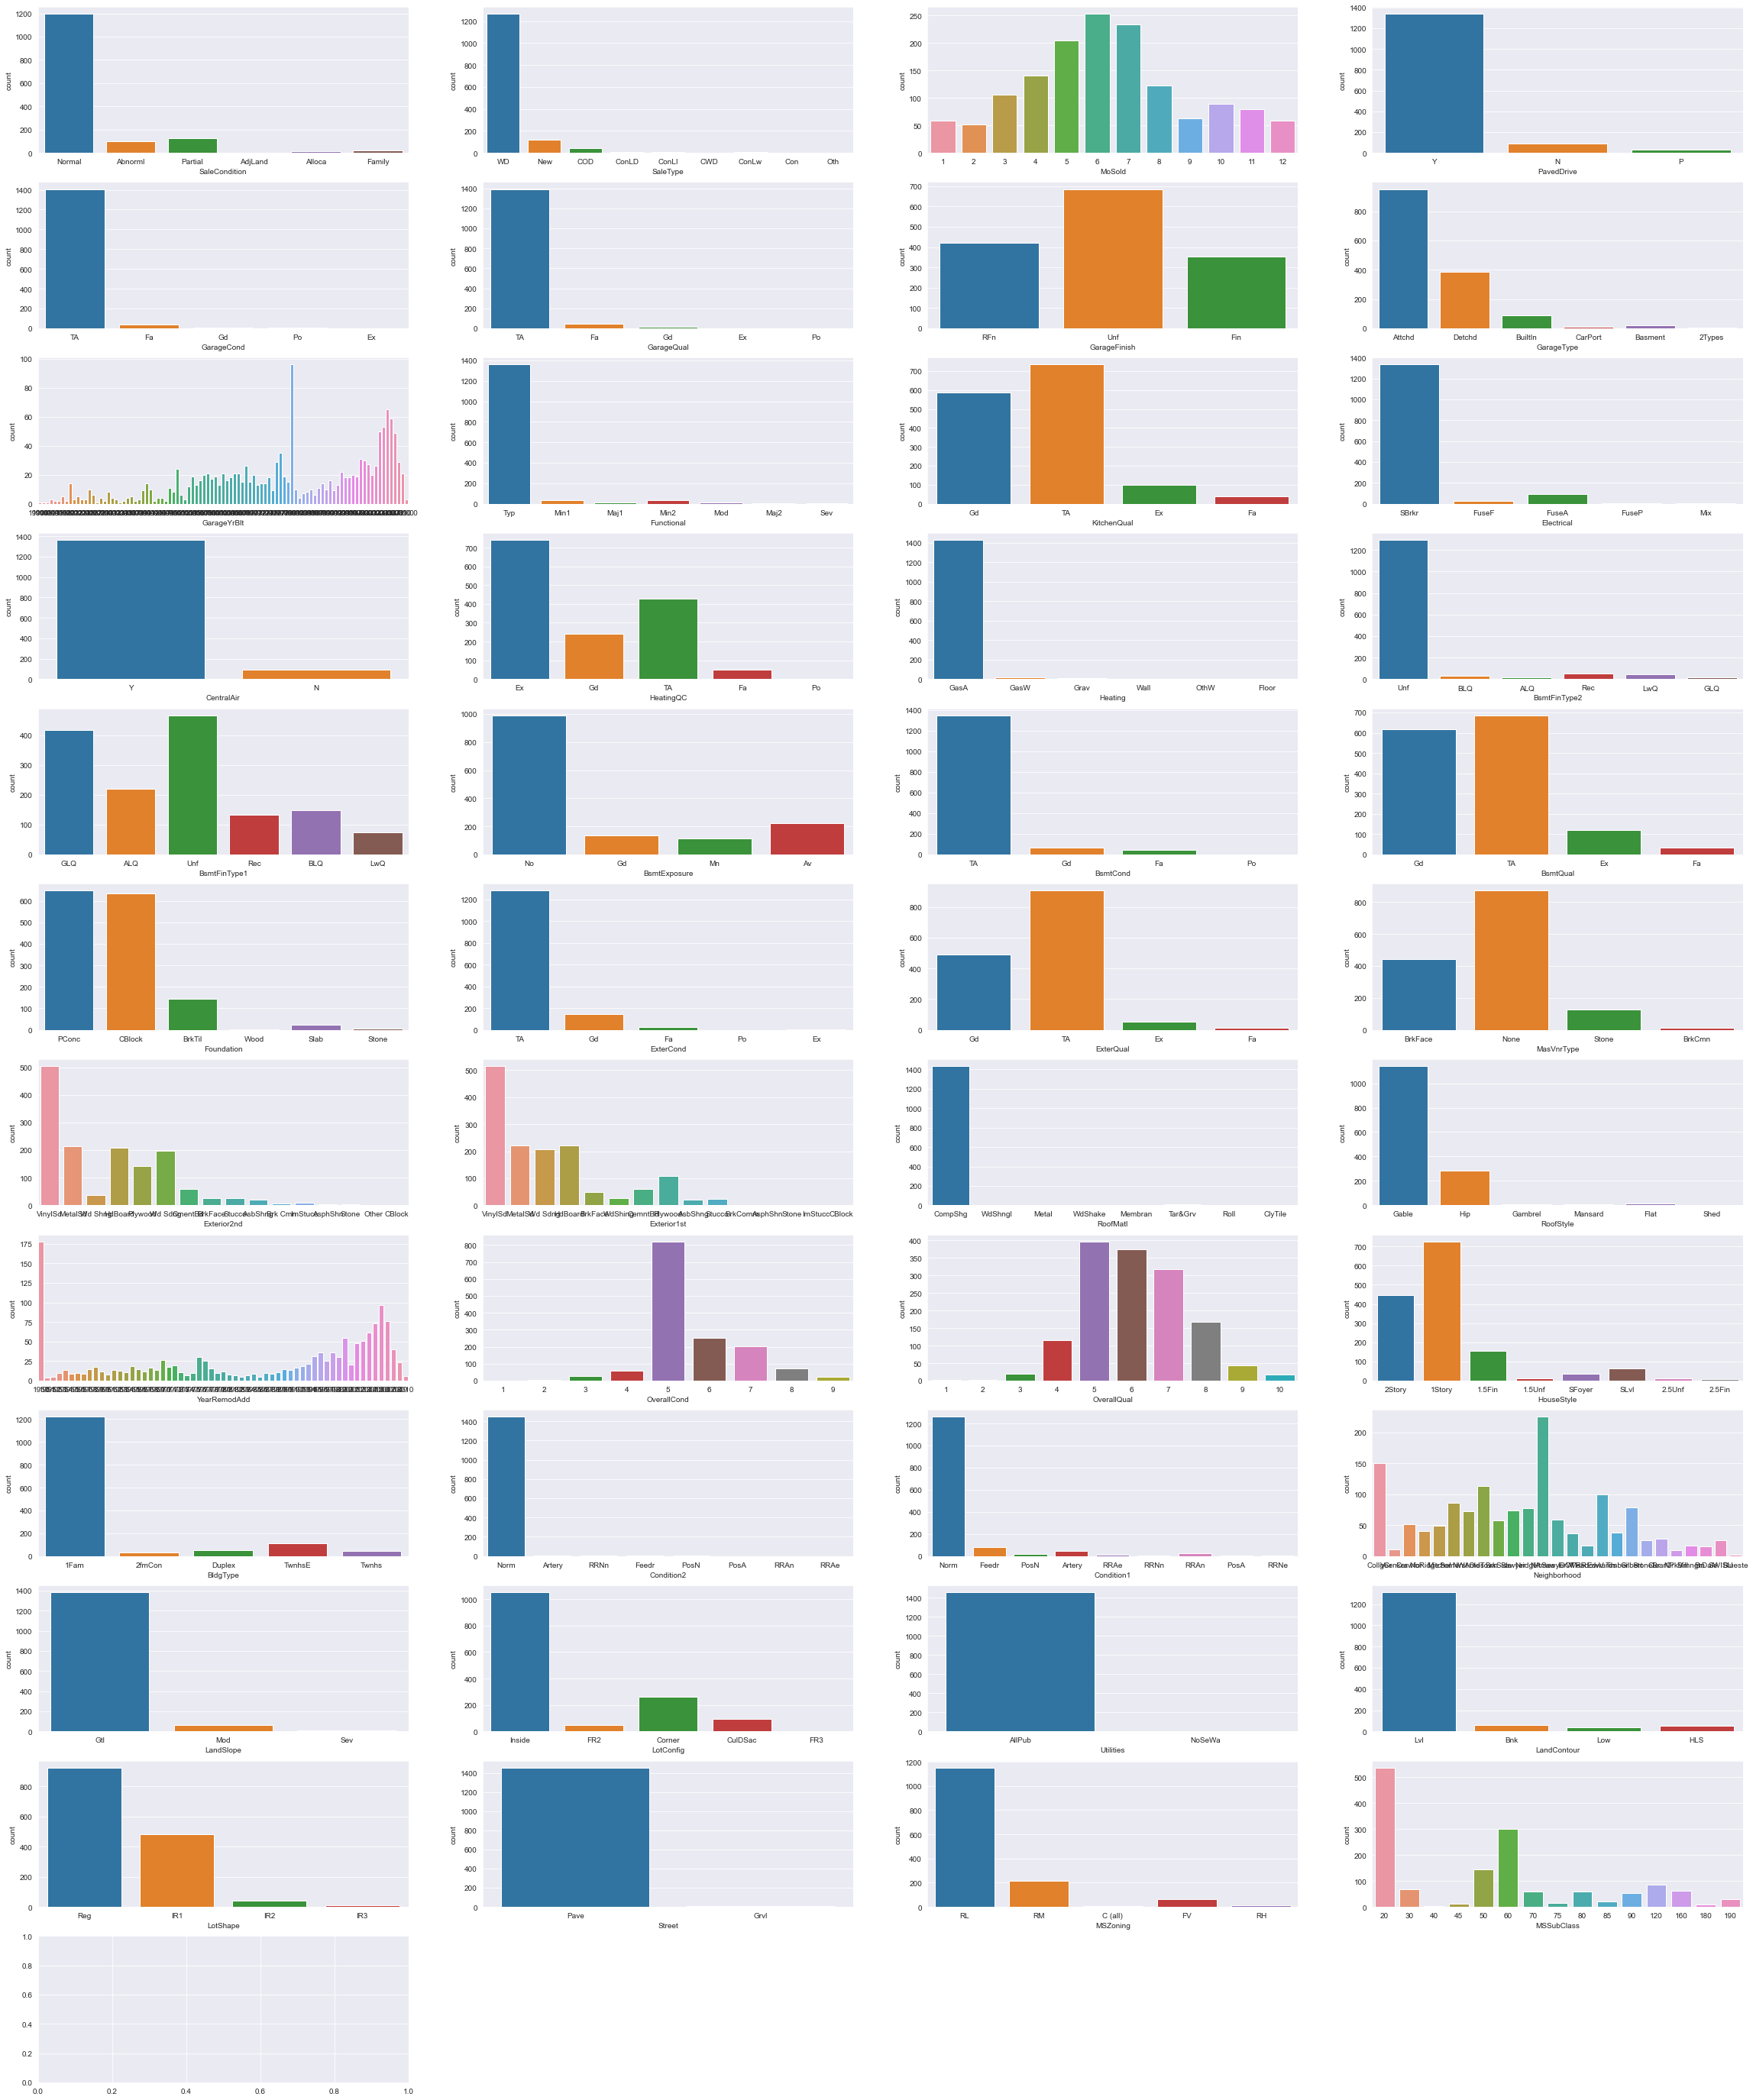

In [20]:
# Count plot to see the distribution
plt.figure(figsize=(40, 50))
l = len(categorical_columns)
for i in range(1, l+1):
    try:
        plt.subplot((l//4)+1,4,i)
        sns.countplot(x=categorical_columns[i], data=df)
    except:
        pass
plt.show()

In [21]:
# List of skewed tables
skewed_tables = [
    "SaleType",
    "PavedDrive",
    "GarageCond",
    "GarageQual", 
    "Functional",
    "Electrical",
    "CentralAir",
    "Heating",
    "BsmtFinType2",
    "BsmtCond",
    "ExterCond",
    "RoofMatl",
    "RoofStyle",
    "Condition2",
    "Condition1",
    "BldgType",
    "LandSlope",
    "LotConfig",
    "Utilities",
    "LandContour",
    "Street",
    "MSZoning"
]

In [22]:
# Removing skewed tables from dataframe and update categorical columns
df.drop(skewed_tables, inplace=True, axis=1)
categorical_columns = [ elem for elem in categorical_columns if elem not in skewed_tables]

In [23]:
# updated categorical columns
categorical_columns

['Age',
 'SaleCondition',
 'MoSold',
 'GarageFinish',
 'GarageType',
 'GarageYrBlt',
 'KitchenQual',
 'HeatingQC',
 'BsmtFinType1',
 'BsmtExposure',
 'BsmtQual',
 'Foundation',
 'ExterQual',
 'MasVnrType',
 'Exterior2nd',
 'Exterior1st',
 'YearRemodAdd',
 'OverallCond',
 'OverallQual',
 'HouseStyle',
 'Neighborhood',
 'LotShape',
 'MSSubClass']

In [24]:
# Check for types in categorical columns
df[categorical_columns].dtypes

Age                int64
SaleCondition     object
MoSold             int64
GarageFinish      object
GarageType        object
GarageYrBlt      float64
KitchenQual       object
HeatingQC         object
BsmtFinType1      object
BsmtExposure      object
BsmtQual          object
Foundation        object
ExterQual         object
MasVnrType        object
Exterior2nd       object
Exterior1st       object
YearRemodAdd       int64
OverallCond        int64
OverallQual        int64
HouseStyle        object
Neighborhood      object
LotShape          object
MSSubClass         int64
dtype: object

In [25]:
# Converting int and float categorical columns to 'object' type
df[['Age', 'MoSold', 'GarageYrBlt', 'YearRemodAdd', 'OverallCond', 'OverallQual', 'MSSubClass']] = df[['Age', 'MoSold', 'GarageYrBlt', 'YearRemodAdd', 'OverallCond', 'OverallQual', 'MSSubClass']].astype('object')

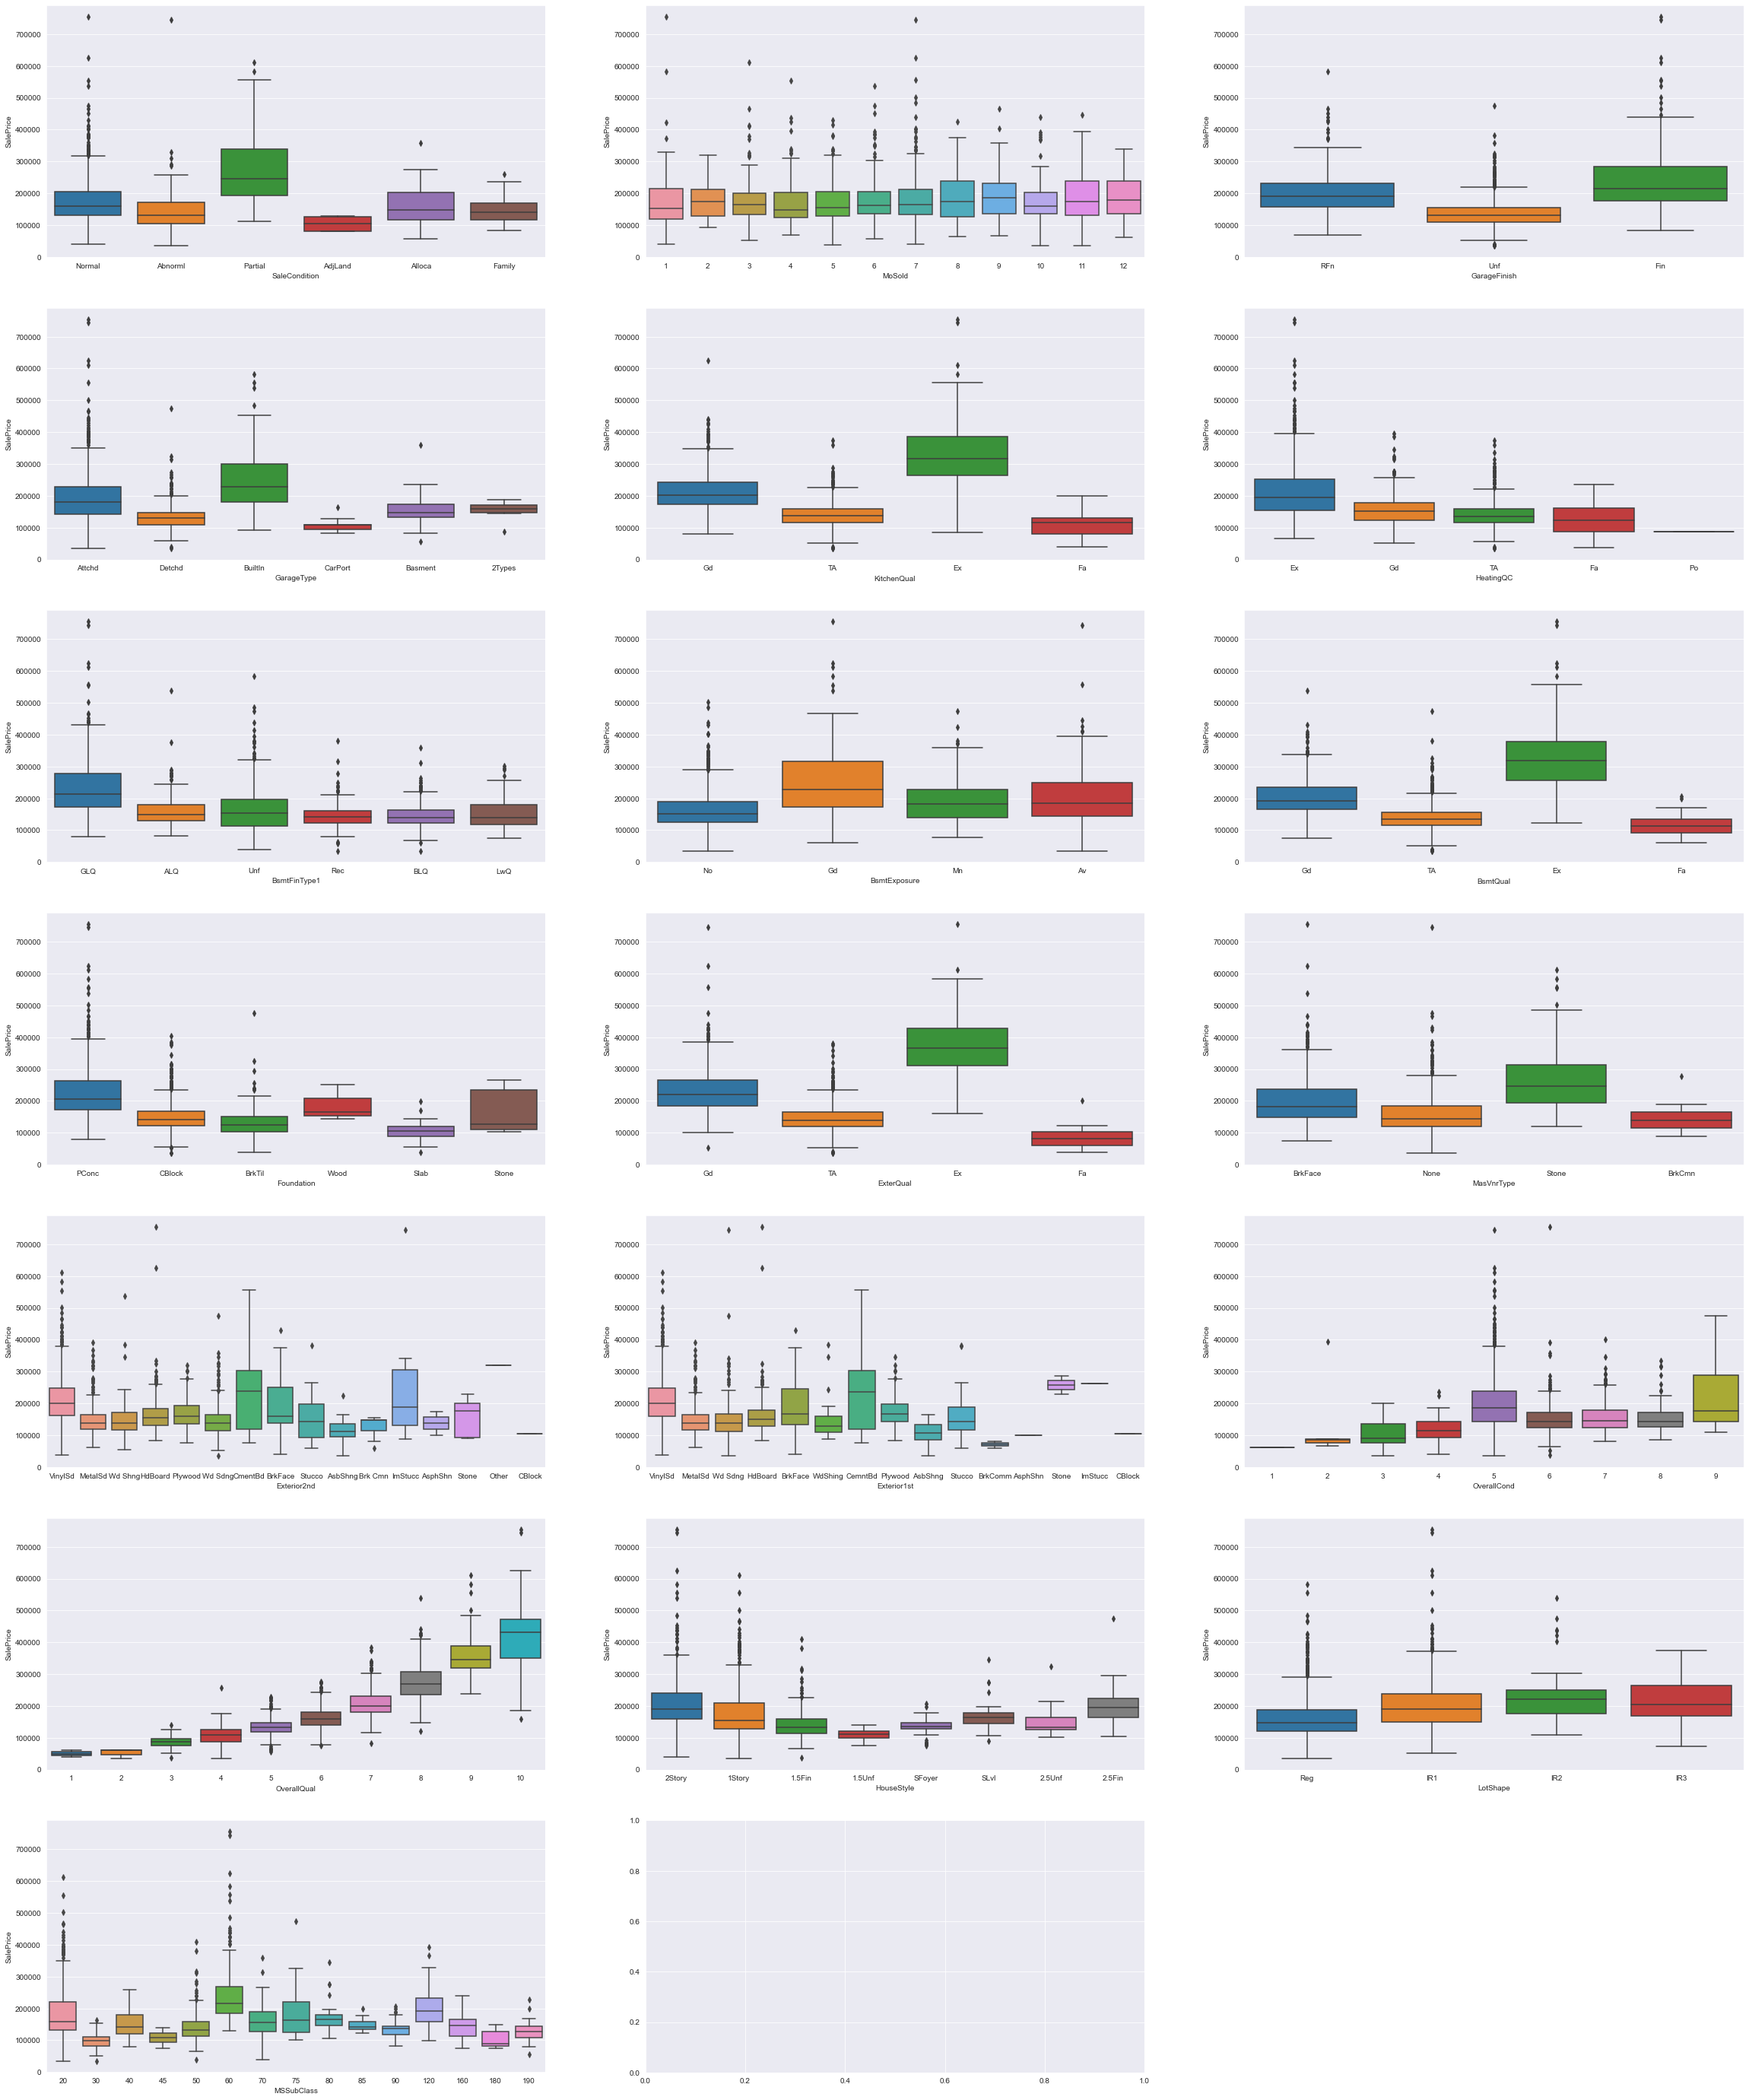

In [26]:
# barplot to see the distribution vs SalePrice
plt.figure(figsize=(40, 50))
categorical_columns_without_year = categorical_columns[:]
categorical_columns_without_year.remove("GarageYrBlt")
categorical_columns_without_year.remove("YearRemodAdd")
categorical_columns_without_year.remove("Neighborhood")
l = len(categorical_columns_without_year)
for i in range(1, l+1):
    try:
        plt.subplot((l//3)+1,3,i)
        sns.boxplot(x=categorical_columns_without_year[i], y="SalePrice", data=df)
    except:
        pass
plt.show()

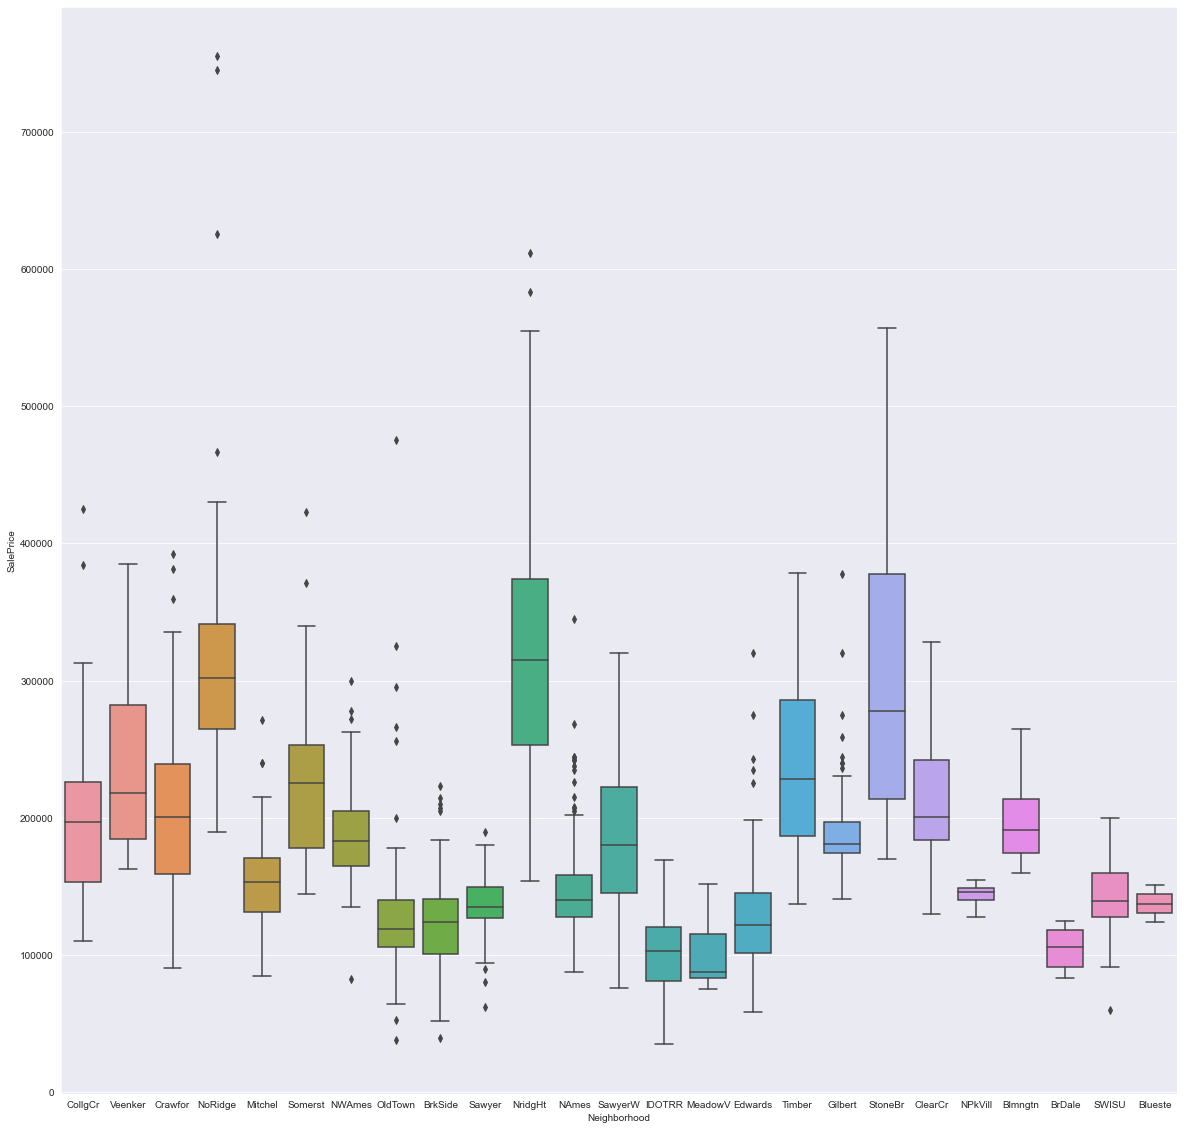

In [27]:
plt.figure(figsize=(20, 20))
sns.boxplot(x="Neighborhood", y="SalePrice", data=df)
plt.show()

In [28]:
# Check for types in categorical columns
df[continuous_columns].dtypes

LotArea            int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
SalePrice          int64
dtype: object

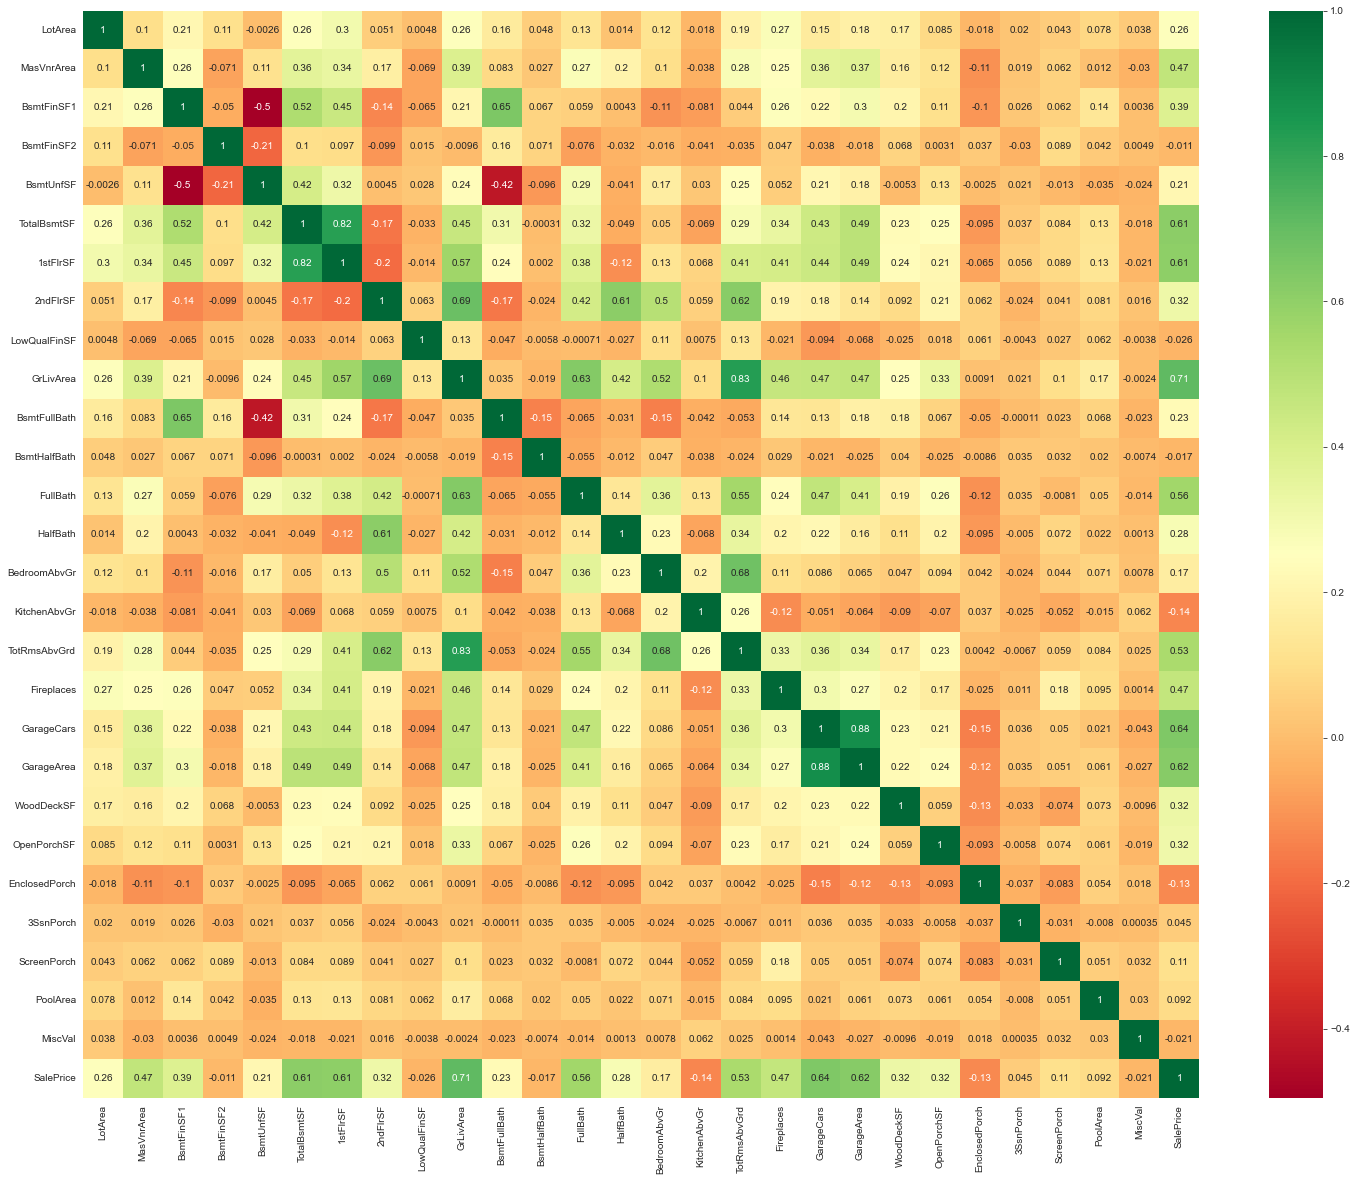

In [29]:
plt.figure(figsize=(25,20))
sns.heatmap(df[continuous_columns].corr(), annot=True, cmap='RdYlGn');

Target variable SalePrice is highly correlated with GrLivArea, GarageCars, GarageArea, FullBath, 1stFlrSF and TotalBsmtSF .

In [30]:
categorical_columns_for_merge = pd.get_dummies(df[categorical_columns], drop_first=True)  # Dummy variables

C:\Users\siddh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [31]:
categorical_columns_for_merge.head()

,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
df = pd.concat([categorical_columns_for_merge, df], axis=1) 

In [33]:
df.head()

,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleCondition,SalePrice,Age
0,0,0,0,0,1,0,0,0,0,0,...,61,0,0,0,0,0,2,Normal,208500,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,Normal,181500,31
2,0,0,0,0,0,0,1,0,0,0,...,42,0,0,0,0,0,9,Normal,223500,7
3,0,0,0,0,0,0,0,0,0,0,...,35,272,0,0,0,0,2,Abnorml,140000,91
4,0,0,0,0,0,0,0,1,0,0,...,84,0,0,0,0,0,12,Normal,250000,8


In [34]:
df.drop(categorical_columns, axis=1, inplace=True)

In [35]:
df.head()

,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,0,0,0,0,1,0,0,0,0,0,...,2,548,0,61,0,0,0,0,0,208500
1,0,0,0,0,0,0,0,0,0,0,...,2,460,298,0,0,0,0,0,0,181500
2,0,0,0,0,0,0,1,0,0,0,...,2,608,0,42,0,0,0,0,0,223500
3,0,0,0,0,0,0,0,0,0,0,...,3,642,0,35,272,0,0,0,0,140000
4,0,0,0,0,0,0,0,1,0,0,...,3,836,192,84,0,0,0,0,0,250000


In [36]:
df_train,df_test = train_test_split(df,train_size=0.7,test_size=0.3,random_state=100)

In [37]:
# Read in the data
y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test

C:\Users\siddh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\siddh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

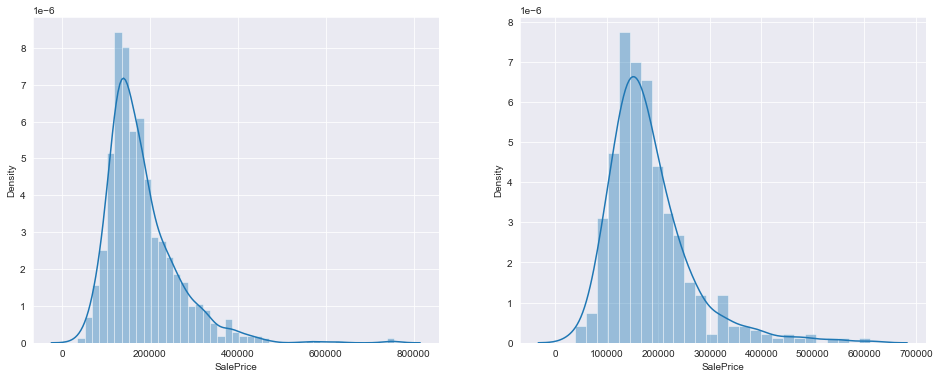

In [38]:
# Let us check if the target variable is normal in both train and test dataset
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(y_train)
plt.subplot(122)
sns.distplot(y_test)

## Rescaling the features - MinMax Scaling

In [39]:
# Instantiaite the object
scaler = MinMaxScaler()

In [40]:
# Fit on data - continuous_columns
continuous_columns.remove('SalePrice')
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.fit_transform(X_test[continuous_columns])

In [41]:
X_train.head()

,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
210,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.00,0.000000,0.000000,0.000000,0.173913,0.0,0.0,0.0,0.0
318,0,0,0,0,0,0,0,0,0,0,...,0.333333,0.75,0.462623,0.396733,0.114723,0.260870,0.0,0.0,0.0,0.0
239,0,0,0,0,0,0,0,0,0,0,...,0.333333,0.25,0.155148,0.000000,0.267686,0.000000,0.0,0.0,0.0,0.0
986,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.25,0.179831,0.459743,0.000000,0.000000,0.0,0.0,0.0,0.0
1416,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.50,0.394922,0.000000,0.000000,0.206522,0.0,0.0,0.0,0.0


## Building Our Model

### Ridge Regression Model


In [42]:
#Ridge
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

# train score
y_train_pred = ridge.predict(X_train)
# test score
y_test_pred = ridge.predict(X_test)

show_metrics(y_train, y_train_pred, y_test, y_test_pred)

R-Squared (Train) = 0.92
R-Squared (Test) = 0.54


[0.9164707829739915, 0.5355917977049792]

In [43]:
# Gridsearch Operation on Training data set
# Objective - Find optimal value of alpha

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
model = Ridge()

model_cv = GridSearchCV(estimator = model,
                        param_grid=params,
                        scoring='r2',
                        cv=5,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [44]:
## View the optimal value of alpha
model_cv.best_params_

{'alpha': 10.0}

In [45]:
# Create a ridge regreesion instance with optimum value alpha=5
ridge = Ridge(alpha=model_cv.best_params_['alpha'])

In [46]:
# Fit the model on training data
ridge.fit(X_train, y_train)

Ridge(alpha=10.0)

In [47]:
# Make predictions
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

In [48]:
# Check metrics
ridge_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.89
R-Squared (Test) = 0.75


In [49]:
# Create a dataframe of ridge cross validation results
ridge_results= pd.DataFrame(model_cv.cv_results_)
ridge_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017799,0.002638,0.005000,1.522896e-06,0.0001,{'alpha': 0.0001},0.718984,0.666781,0.538195,0.706515,...,0.657873,0.064037,26,0.923805,0.937367,0.938304,0.922743,0.928713,0.930187,0.006569
1,0.015799,0.000748,0.005401,4.898437e-04,0.001,{'alpha': 0.001},0.719677,0.670147,0.553543,0.711180,...,0.663415,0.059270,25,0.923804,0.937362,0.938227,0.922741,0.928709,0.930169,0.006550
2,0.017201,0.001326,0.006200,7.465960e-04,0.01,{'alpha': 0.01},0.725572,0.675524,0.575658,0.729226,...,0.677289,0.055445,24,0.923769,0.937317,0.938028,0.922684,0.928619,0.930084,0.006515
3,0.019400,0.001357,0.006602,8.010030e-04,0.05,{'alpha': 0.05},0.742675,0.681340,0.619104,0.755170,...,0.702218,0.048778,23,0.923415,0.937079,0.937367,0.922385,0.928043,0.929658,0.006465
4,0.018599,0.001018,0.005800,7.481512e-04,0.1,{'alpha': 0.1},0.756131,0.685707,0.648477,0.772143,...,0.718940,0.045739,22,0.922881,0.936723,0.936445,0.921879,0.927303,0.929046,0.006420
5,0.019201,0.001470,0.006400,4.894591e-04,0.2,{'alpha': 0.2},0.773404,0.691938,0.681363,0.791116,...,0.738244,0.043911,21,0.921807,0.936007,0.934753,0.920745,0.925961,0.927855,0.006399
6,0.027400,0.004841,0.007200,9.794531e-04,0.3,{'alpha': 0.3},0.784933,0.696656,0.700887,0.802357,...,0.750117,0.043514,19,0.920792,0.935333,0.933293,0.919624,0.924774,0.926763,0.006429
7,0.020200,0.002400,0.007401,4.915962e-04,0.4,{'alpha': 0.4},0.793520,0.700552,0.714480,0.810194,...,0.758597,0.043456,18,0.919842,0.934702,0.932014,0.918568,0.923702,0.925766,0.006482
8,0.021600,0.001357,0.006801,4.005684e-04,0.5,{'alpha': 0.5},0.800293,0.703905,0.724770,0.816146,...,0.765139,0.043486,17,0.918954,0.934107,0.930874,0.917582,0.922721,0.924848,0.006544
9,0.022400,0.007338,0.007000,2.529865e-03,0.6,{'alpha': 0.6},0.805833,0.706858,0.732975,0.820907,...,0.770431,0.043532,16,0.918119,0.933542,0.929841,0.916661,0.921813,0.923995,0.006609


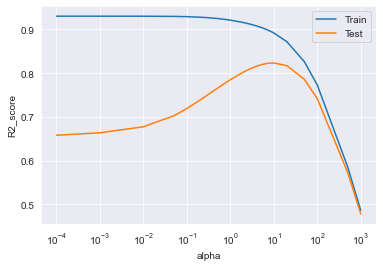

In [50]:
## Plotting R2 score vs alpha values
plt.plot(ridge_results['param_alpha'], ridge_results['mean_train_score'], label='Train')
plt.plot(ridge_results['param_alpha'], ridge_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

### Lassso Regression Model


In [51]:
#Lasso
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

# train score
y_train_pred = lm.predict(X_train)
# test score
y_test_pred  = lm.predict(X_test)

show_metrics(y_train, y_train_pred, y_test, y_test_pred)

R-Squared (Train) = 0.92
R-Squared (Test) = 0.48


C:\Users\siddh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.663e+11, tolerance: 6.381e+08
  model = cd_fast.enet_coordinate_descent(


[0.916460948053967, 0.47972450382192156]

In [52]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso = Lasso()

# cross validation

lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lasso_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [53]:
# View the optimal value of alpha
lasso_cv.best_params_

{'alpha': 100}

In [54]:
# Create a ridge regreesion instance with optimum value alpha=5
lasso = Lasso(alpha=lasso_cv.best_params_['alpha'])

In [55]:
# Fit the model on training data
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [56]:
# Make predictions
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

In [57]:
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.89
R-Squared (Test) = 0.75


In [58]:
lasso_cv_results= pd.DataFrame(lasso_cv.cv_results_)

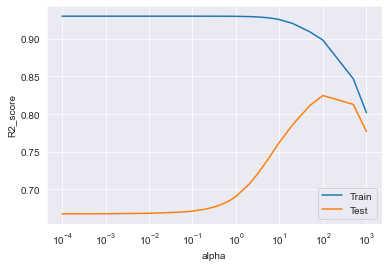

In [59]:
## Plotting R2 score vs alpha values
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'], label='Train')
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

### Comparing Ridge and Lasso Models

In [60]:
## Setting float display options
pd.options.display.float_format = "{:,.2f}".format

In [61]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)'],
            'Ridge Regression' : ridge_metrics,
            'Lasso Regression' : lasso_metrics
        }

final_metric = pd.DataFrame(lr_table, columns = ['Metric', 'Ridge Regression', 'Lasso Regression'] )
final_metric.set_index('Metric')

,Ridge Regression,Lasso Regression
Metric,,
R2 Score (Train),0.89,0.89
R2 Score (Test),0.75,0.75


## Conclusions

In [62]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

C:\Users\siddh\AppData\Local\Temp\ipykernel_17128\4063381995.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train.columns


In [63]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [64]:
betas.shape

(450, 2)

In [65]:
betas[betas['Lasso']==0].shape

(332, 2)

The above 332 features out of 450 (from X_train) have been removed by Lasso. In this way, lasso performs feature selection

### Features selected by Lasso

In [66]:
betas.loc[betas['Lasso']!=0, 'Lasso']

Age_1          5,986.58
Age_3          5,130.64
Age_9          4,156.84
Age_11        13,953.04
Age_12        -2,773.97
                 ...   
GarageCars    41,733.67
WoodDeckSF     6,354.70
OpenPorchSF     -195.75
3SsnPorch      3,189.41
ScreenPorch    7,900.32
Name: Lasso, Length: 118, dtype: float64

### Top 10 coefficients of Ridge regression in descending order

In [67]:
betas['Ridge'].sort_values(ascending=False)[:10]

OverallQual_10         38,023.61
GrLivArea              37,625.26
Neighborhood_NoRidge   37,518.74
2ndFlrSF               36,646.10
OverallQual_9          33,915.49
FullBath               30,719.28
GarageCars             28,898.25
TotRmsAbvGrd           28,456.67
1stFlrSF               28,232.57
Neighborhood_NridgHt   23,325.94
Name: Ridge, dtype: float64

### Top 10 coefficients of Lasso in descending order

In [68]:
betas['Lasso'].sort_values(ascending=False)[:10]

GrLivArea              169,592.64
OverallQual_10          83,730.40
OverallQual_9           72,429.57
Neighborhood_NoRidge    45,916.99
GarageCars              41,733.67
OverallQual_8           33,967.02
2ndFlrSF                32,386.40
Neighborhood_NridgHt    27,604.70
FullBath                26,541.46
Neighborhood_Crawfor    24,453.85
Name: Lasso, dtype: float64

### Variables significant in predicting the price of a house:

`GrLivArea`, `OverallQua`, `Neighbourhood`, `Garage Cars`, `Second Floor Area`,  `First Floor Area` and `Full bath`

## Subjective Question Changes

### Optimal Value of lamda for ridge : 10

### Optimal Value of lamda for lasso : 100

#### If we choose to double the value for alpha

In [69]:
ridge = Ridge(alpha=20)

# Fit the model on training data
ridge.fit(X_train, y_train)

Ridge(alpha=20)

In [70]:
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

In [71]:
show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.87
R-Squared (Test) = 0.76


[0.871898099983102, 0.7646448272805296]

In [72]:
lasso = Lasso(alpha=200)

# Fit the model on training data
lasso.fit(X_train, y_train)

Lasso(alpha=200)

In [73]:
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

In [74]:
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.88
R-Squared (Test) = 0.73


#### Most important predictor after we doublt the alpha

In [75]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

C:\Users\siddh\AppData\Local\Temp\ipykernel_17128\4063381995.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train.columns


In [76]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [77]:
betas['Ridge'].sort_values(ascending=False)[:10]

Neighborhood_NoRidge   31,451.53
GrLivArea              30,236.76
OverallQual_10         30,126.92
OverallQual_9          28,414.49
2ndFlrSF               27,180.65
FullBath               26,521.03
TotRmsAbvGrd           26,191.01
GarageCars             25,528.54
1stFlrSF               23,685.68
Fireplaces             23,111.74
Name: Ridge, dtype: float64

In [78]:
betas['Lasso'].sort_values(ascending=False)[:10]

GrLivArea              178,599.11
OverallQual_10          84,020.96
OverallQual_9           74,505.11
GarageCars              44,560.62
Neighborhood_NoRidge    44,173.49
OverallQual_8           35,400.12
FullBath                24,918.25
Neighborhood_NridgHt    23,744.76
Neighborhood_Crawfor    20,277.74
Fireplaces              20,115.91
Name: Lasso, dtype: float64

The most important predictor variables after we double the alpha values are:-
- Neighborhood_NoRidge
- GrLivArea
- OverallQual_10
- OverallQual_9
- FullBath
- Neighborhood_Crawfor
- Neighborhood_NridgHt
- Fireplaces
- TotRmsAbvGrd

### Remove top five lasso features:

In [79]:
top5 = ['OverallQual_9', 'GrLivArea', 'OverallQual_10', 'Neighborhood_NoRidge', 'GarageCars']

In [80]:
# drop them from train and test data
X_train_dropped = X_train.drop(top5, axis=1)
X_test_dropped = X_test.drop(top5, axis=1)

In [81]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso = Lasso()

# cross validation

lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lasso_cv.fit(X_train_dropped, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [82]:
## View the optimal value of alpha
lasso_cv.best_params_

{'alpha': 100}

In [83]:
# Now we will build the lasso model with double value of alpha i.e. 0.002
lasso = Lasso(alpha=100)

# Fit the model on training data
lasso.fit(X_train_dropped, y_train)

Lasso(alpha=100)

In [84]:
# Make predictions
y_train_pred = lasso.predict(X_train_dropped)
y_pred = lasso.predict(X_test_dropped)

In [85]:
betas = pd.DataFrame(index=X_train_dropped.columns)
betas.rows = X_train_dropped.columns

C:\Users\siddh\AppData\Local\Temp\ipykernel_17128\967474225.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_dropped.columns


In [87]:
betas['Lasso'] = lasso.coef_

In [88]:
betas['Lasso'].sort_values(ascending=False)[:5]

1stFlrSF     158,072.73
2ndFlrSF     118,884.51
GarageArea    36,297.35
MasVnrArea    32,100.42
Age_11        28,868.85
Name: Lasso, dtype: float64